In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt

import tensorflow as tf
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# from prophet import Prophet

%matplotlib inline

In [2]:
model_dir = "./Models"
# model_dir = '/content/drive/MyDrive/UNIVERSITAT/Inteligencia artificial/Treball/Models'
dataset_dir = "./Dataset"
# dataset_dir = '/content/drive/MyDrive/UNIVERSITAT/Inteligencia artificial/Treball/Dataset'

In [3]:
columns = [
    'year', 'month', 'day', 'hour', 'minute', 'second', 'glucose_level', 'finger_stick', 'basal', 'bolus', 'sleep',
    'work', 'stressors', 'hypo_event', 'illness', 'exercise', 'basis_heart_rate',
    'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature',
    'basis_step', 'basis_sleep', 'meal', 'type_of_meal'
]

## UTILS

In [4]:
def create_time_index(dataset, time_index):
    """
    Combines separate date and time columns into a single datetime column in a pandas DataFrame.
    
    Args:
      dataset (pandas.DataFrame): The DataFrame containing the date and time columns.
    
    Returns:
      pandas.DataFrame: The modified DataFrame with the combined datetime column and optional removal of the original columns.
    
    Raises:
      ValueError: If any of the date/time columns are missing or have incorrect data types.
    """
    
    # Check for presence and data type of all required columns
    required_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
    if not all(col in dataset.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {', '.join(set(required_columns) - set(dataset.columns))}")
    
    # Combine date and time columns into a single datetime column
    dataset['time'] = pd.to_datetime(
        {
            'year': dataset['year'],
            'month': dataset['month'],
            'day': dataset['day'],
            'hour': dataset['hour'],
            'minute': dataset['minute'],
            'second': dataset['second']
        }
    )

    # convert the datetime column to an integer
    dataset['timestamp'] = dataset['time'].astype('int64')

    # divide the resulting integer by the number of nanoseconds in a second
    dataset['timestamp'] = dataset['timestamp'].div(10**9)

    # Set the combined datetime column as the index
    if time_index:
        dataset.set_index('timestamp', inplace=True)
    
    # Optionally remove the original columns if desired
    dataset.drop(columns=required_columns + ['time'], inplace=True)
    
    return dataset

In [5]:
def preprocess_data(df, time_index=True, impute_strategy='mean', scale_data=True, encode_categorical=True, select_features=True):
    """
    Preprocesses the input DataFrame:
    1. Replaces commas with periods in all values.
    2. Converts all values to float.
    3. Optionally imputes missing values.
    4. Optionally scales the data.
    5. Optionally encodes categorical variables.
    6. Optionally selects the most relevant features.
    7. Optionally creates a time index.
    
    Args:
        df (DataFrame): Input DataFrame.
        time_index (bool): Whether to create a time index (default True).
        impute_strategy (str): Strategy to use for imputing missing values ('mean', 'median', 'most_frequent').
        scale_data (bool): Whether to scale the data (default True).
        encode_categorical (bool): Whether to encode categorical variables (default True).
        select_features (bool): Whether to select the most relevant features (default True).

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    # Replace commas with periods
    df = df.replace(',', '.', regex=True)
    
    # Convert all values to float
    df = df.astype(float)

    # Create time index if specified
    df = create_time_index(df, time_index)  # Assuming create_time_index function is defined
    
    # # Impute missing values
    # if impute_strategy:
    #     imputer = SimpleImputer(strategy=impute_strategy)
    #     df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # # Scale the data
    # if scale_data:
    #     scaler = StandardScaler()
    #     df[df.columns] = scaler.fit_transform(df[df.columns])
    
    # Encode categorical variables
    # if encode_categorical:
    #     # Assuming the last column is the target column and the rest are features
    #     features = df.iloc[:, :-1]
    #     target = df.iloc[:, -1]
    #     encoder = LabelEncoder()
    #     features = features.apply(encoder.fit_transform)
    #     df = pd.concat([features, target], axis=1)
    
    # Select the most relevant features
    # if select_features:
    #     # Assuming the last column is the target column and the rest are features
    #     features = df.iloc[:, :-1]
    #     target = df.iloc[:, -1]
    #     selector = SelectKBest(score_func=f_regression, k=min(10, len(features.columns)))
    #     features_selected = selector.fit_transform(features, target)
    #     selected_columns = features.columns[selector.get_support()]
    #     df = pd.DataFrame(features_selected, columns=selected_columns)
    #     df = pd.concat([df, target], axis=1)
        
    return df

In [6]:
def to_sequences(obs, seq_size, prediction_time):
    """
    This function creates batches of sequences and targets for training a model.
    
    Args:
        obs 
        (list): The list of observations (time series data).
        seq_size (int): The size of the sequence window.
        prediction_time (int): The number of steps ahead to predict.
    
    Returns:
        tuple: A tuple containing two NumPy arrays:
          - x: The sequences (training data).
          - y: The targets (predictions).
    """
    x = []
    y = []

    # Loop through observations, ensuring enough data for window and target
    for i in range(seq_size, len(obs) - prediction_time - 1):
        # Get the sequence window using slicing (clarified using obs[(i-seq_size):i])
        window = obs[(i - seq_size):i]
        window = [[x] for x in window]
        
        # Check if window extraction is within bounds
        if len(window) != seq_size:
            raise ValueError("Sequence size exceeds available data at index", i)
        
        # Extract the target value
        after_window = obs[i + prediction_time - 1]       
        
        # Append sequence and target
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [7]:
def to_sequences_multi(obs, seq_size, prediction_time, sequence_columns, target_columns):
    """
    This function creates batches of sequences and targets for training a model.

    Args:
        obs (list): The list of observations (time series data).
        seq_size (int): The size of the sequence window.
        prediction_time (int): The number of steps ahead to predict.
        sequence_columns (list): The list of column indices to be considered as sequence values.
        target_columns (list): The list of column indices to be considered as prediction values.

    Returns:
        tuple: A tuple containing two NumPy arrays:
          - x: The sequences (training data).
          - y: The targets (predictions).
    """
    # Check if provided columns exist in the DataFrame
    if not all(col in obs.columns for col in sequence_columns):
        raise ValueError("One or more sequence columns not found in DataFrame")
    if not all(col in obs.columns for col in target_columns):
        raise ValueError("One or more target columns not found in DataFrame")

    # Check if sequence size and prediction time are valid
    if seq_size < 1:
        raise ValueError("Sequence size must be greater than zero")
    if prediction_time < 1:
        raise ValueError("Prediction time must be greater than zero")
        
    x = []
    y = []

    # Loop through observations, ensuring enough data for window and target
    for i in range(seq_size, len(obs) - prediction_time - 1):
        # Get the sequence window using slicing
        window = obs.iloc[i - seq_size:i][sequence_columns].values

        # Extract the target value
        after_window = obs.iloc[i + prediction_time - 1][target_columns].values

        # # Append sequence and target
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

## ANALYSIS

### PRE PROCESSING

In [13]:
number = 588
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)

train = preprocess_data(train)
train.head()

C:\Users\tesfa\AppData\Local\Temp/ipykernel_10844/4097949453.py:33: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  dataset['timestamp'] = dataset['time'].astype('int64')


,glucose_level,finger_stick,basal,bolus,sleep,work,stressors,hypo_event,illness,exercise,basis_heart_rate,basis_gsr,basis_skin_temperature,basis_air_temperature,basis_step,basis_sleep,meal,type_of_meal
timestamp,,,,,,,,,,,,,,,,,,
1.630306e+09,0.0,169.0,1.4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
1.630306e+09,0.0,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.630306e+09,0.0,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.630307e+09,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.630307e+09,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PLOTTING

<AxesSubplot:xlabel='timestamp', ylabel='glucose_level'>

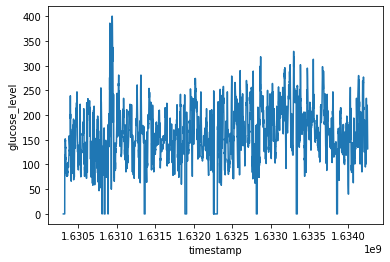

In [14]:
sns.lineplot(y=train['glucose_level'], x=train.index)

In [ ]:
# Loop through each column and create a line plot
for column in train.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=train, x=train.index, y=train[column])
    plt.title(f'{column.capitalize()} Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(column.capitalize())
    plt.show()

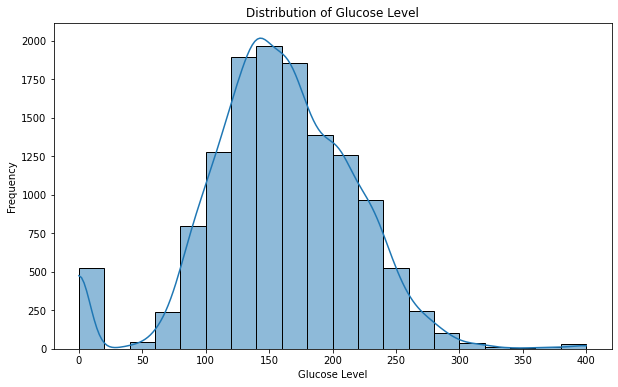

In [15]:
# Histograms
plt.figure(figsize=(10, 6))
sns.histplot(train['glucose_level'], bins=20, kde=True)
plt.title('Distribution of Glucose Level')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

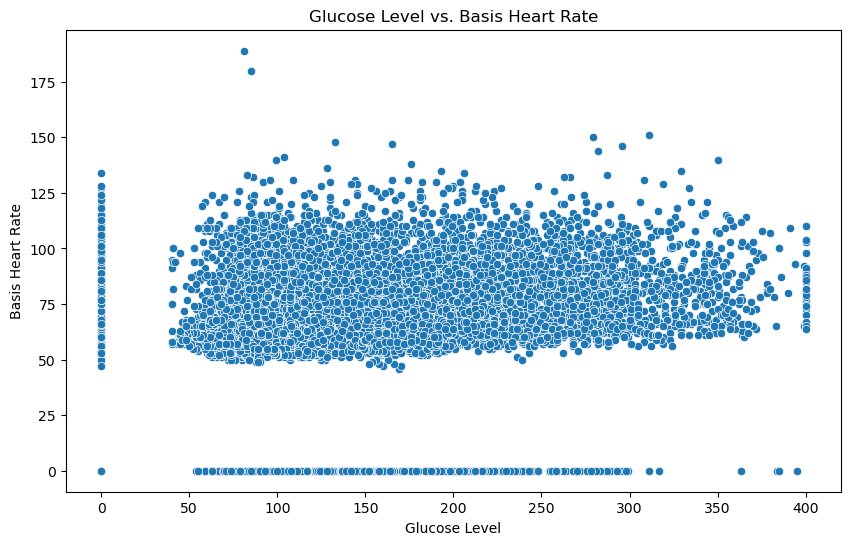

In [157]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['glucose_level'], y=train['basis_heart_rate'])
plt.title('Glucose Level vs. Basis Heart Rate')
plt.xlabel('Glucose Level')
plt.ylabel('Basis Heart Rate')
plt.show()

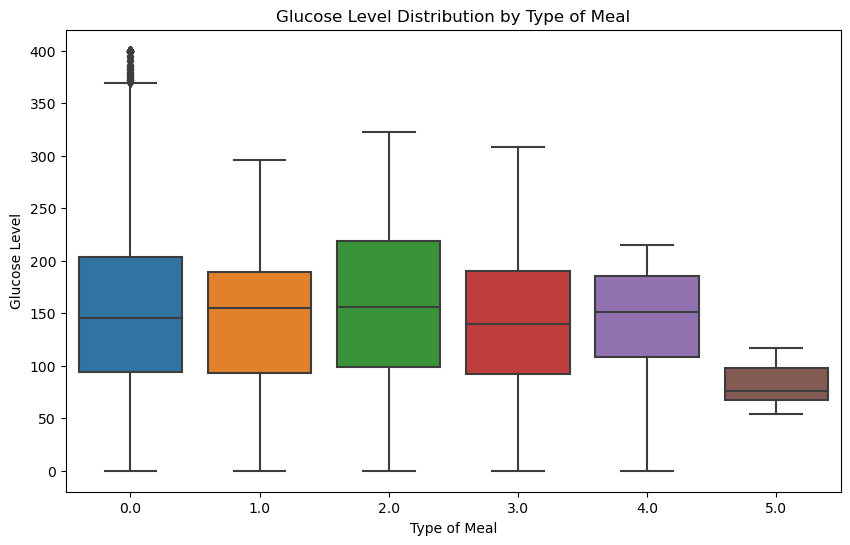

In [158]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['type_of_meal'], y=train['glucose_level'])
plt.title('Glucose Level Distribution by Type of Meal')
plt.xlabel('Type of Meal')
plt.ylabel('Glucose Level')
plt.show()

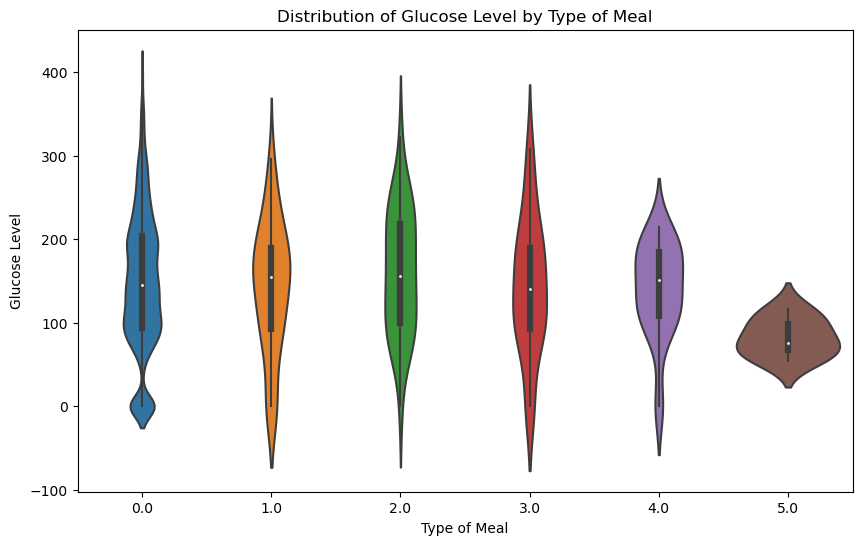

In [159]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=train['type_of_meal'], y=train['glucose_level'])
plt.title('Distribution of Glucose Level by Type of Meal')
plt.xlabel('Type of Meal')
plt.ylabel('Glucose Level')
plt.show()

C:\Users\tesfa\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

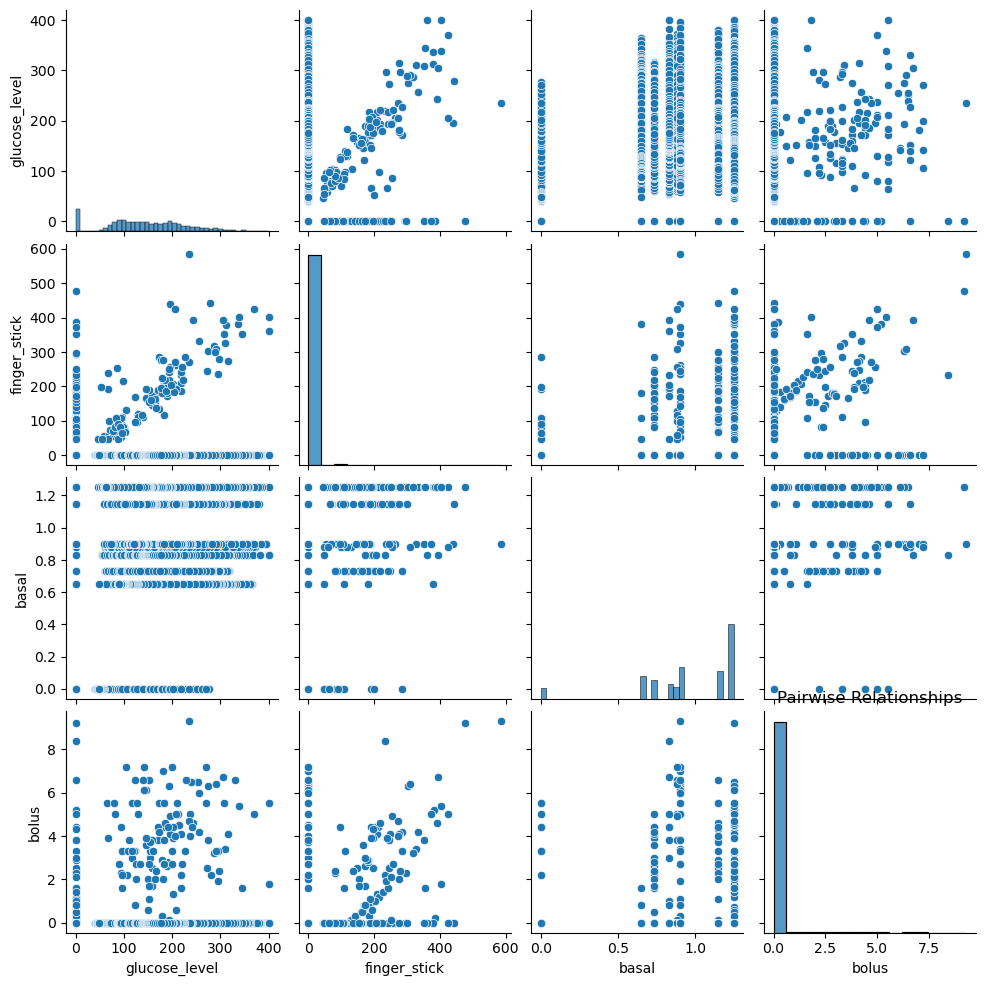

In [160]:
# Pair plot
plt.figure(figsize=(10, 10))
sns.pairplot(train[['glucose_level', 'finger_stick', 'basal', 'bolus']])
plt.title('Pairwise Relationships')
plt.show()

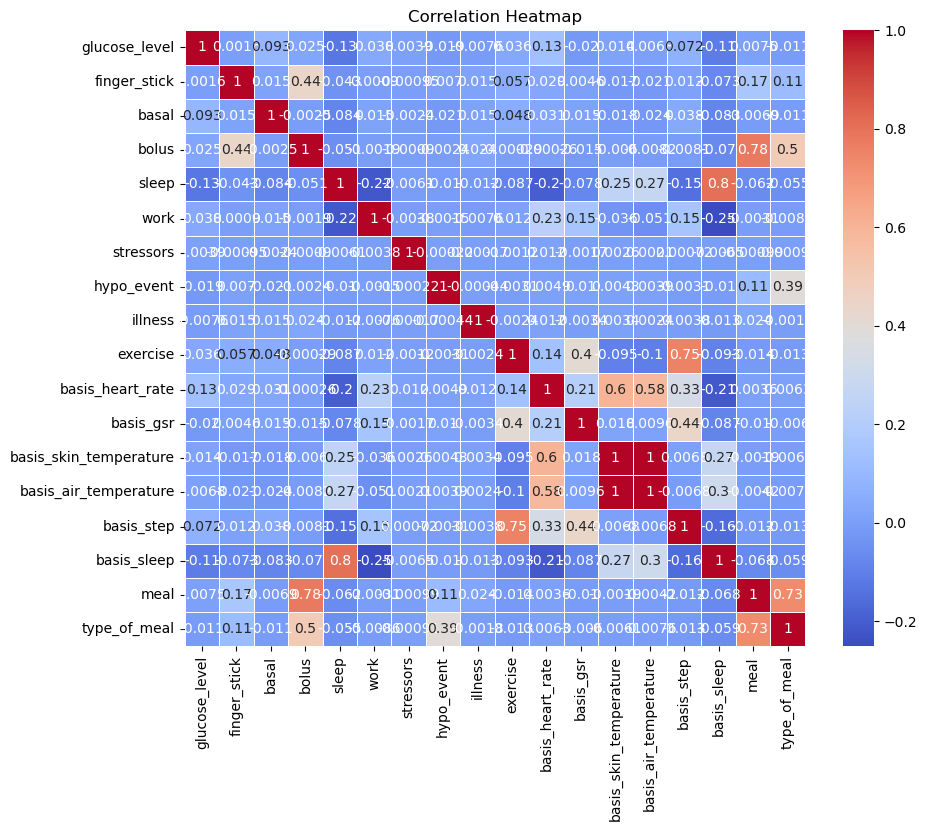

In [161]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

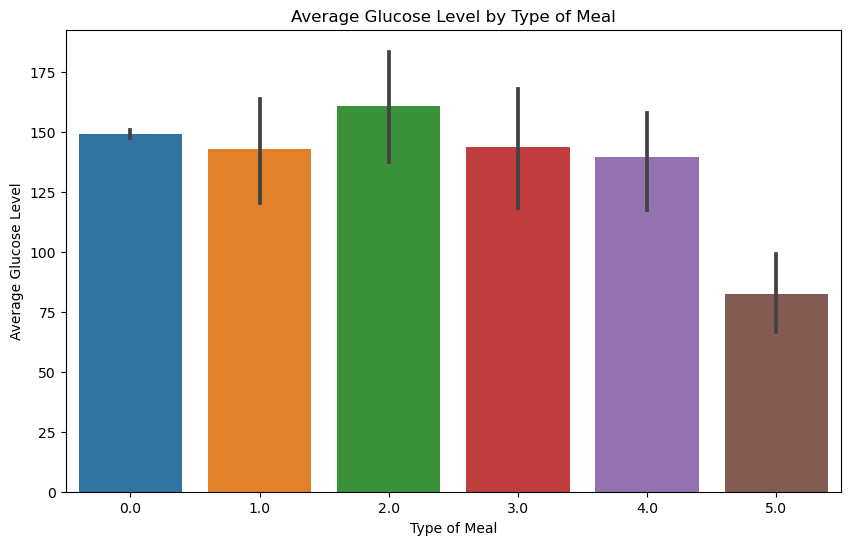

In [162]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=train['type_of_meal'], y=train['glucose_level'])
plt.title('Average Glucose Level by Type of Meal')
plt.xlabel('Type of Meal')
plt.ylabel('Average Glucose Level')
plt.show()

### CORRELATION AND VARIANCE

In [17]:
# Define weights for correlation and variance
correlation_weight = 0.5  # Adjust the weight as needed
variance_weight = 0.5     # Adjust the weight as needed

# Normalize correlation and variance
normalized_corr = (correlation - correlation.min()) / (correlation.max() - correlation.min())
normalized_var = (variance - variance.min()) / (variance.max() - variance.min())

# Calculate combined score
combined_score = (correlation_weight * normalized_corr + variance_weight * normalized_var) / (correlation_weight + variance_weight)

# Sort columns by combined score
sorted_columns_combined = combined_score.sort_values(ascending=False).index

print("Columns sorted by combined score:")
print(sorted_columns_combined)

Columns sorted by combined score:
Index(['basis_heart_rate', 'basis_sleep', 'basis_step', 'basal',
       'finger_stick', 'basis_skin_temperature', 'basis_air_temperature',
       'work', 'exercise', 'bolus', 'meal', 'stressors', 'illness',
       'type_of_meal', 'hypo_event', 'basis_gsr', 'sleep'],
      dtype='object')


### PCA

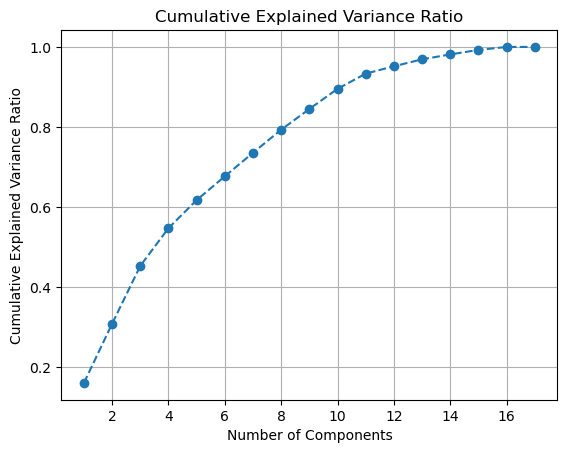

In [15]:
# Extract features and target (if applicable)
X = train.drop(columns=['glucose_level']) 

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyze the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Assuming 'pca' is your PCA object
components_df = pd.DataFrame(pca.components_, columns=X.columns)
# print(components_df)

# Decide on the number of components to keep and transform the data
# Based on the plot, decide the number of components to keep
n_components = 10  # Example: keep the first 10 components
pca = PCA(n_components=n_components)
X_final = pca.fit_transform(X_scaled)

### RFR

In [13]:
# Extract features and target
X = train.drop(columns=['glucose_level'])
y = train['glucose_level']

# Calculate feature importance using Random Forest
rf = RandomForestRegressor()
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print top features by importance
print("Top features by importance:")
print(feature_importance.head(10))  # Adjust the number as needed

# Calculate correlation with the target variable
correlation = train.corr()['glucose_level'].abs().sort_values(ascending=False)

# Print top features by correlation
print("\nTop features by correlation with target variable:")
print(correlation.head(10))  # Adjust the number as needed

Top features by importance:
basis_gsr                 0.178861
basis_heart_rate          0.168873
basis_skin_temperature    0.151297
basis_air_temperature     0.150883
basal                     0.122837
basis_sleep               0.073440
work                      0.044464
basis_step                0.042898
sleep                     0.036204
finger_stick              0.011845
dtype: float64

Top features by correlation with target variable:
glucose_level       1.000000
basis_heart_rate    0.130230
sleep               0.127935
basis_sleep         0.109376
basal               0.092939
basis_step          0.072125
work                0.038157
exercise            0.036349
bolus               0.024505
basis_gsr           0.020221
Name: glucose_level, dtype: float64


### TSNE

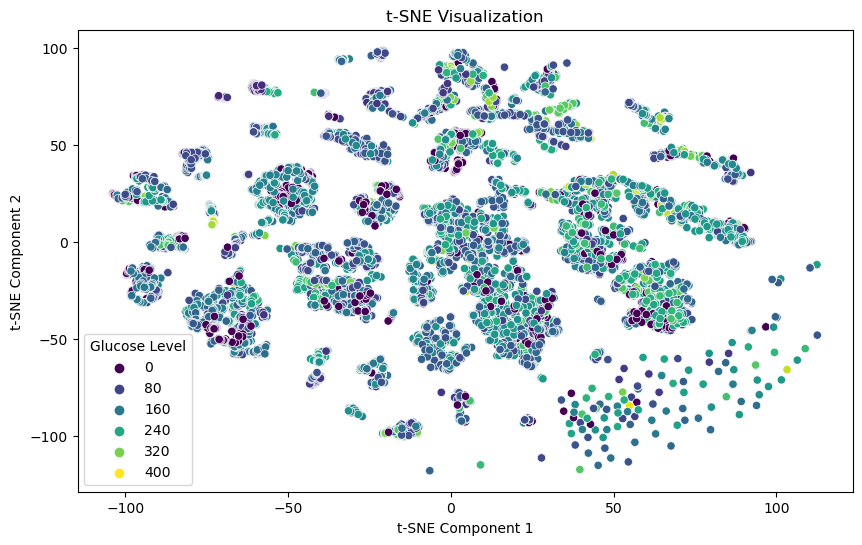

In [165]:
# Preprocess the data
X = train.drop(columns=['glucose_level'])  # Drop target column if applicable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using t-SNE
reducer = TSNE()
X_reduced = reducer.fit_transform(X_scaled)

# Visualize reduced dimensionality data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=train['glucose_level'], palette='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Glucose Level')
plt.show()

### UMAP

In [ ]:
# !pip install umap-learn

In [ ]:
import umap.umap_ as umap
# Preprocess the data
X = train.drop(columns=['glucose_level'])  # Drop target column if applicable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using UMAP
reducer = umap.UMAP()
X_reduced = reducer.fit_transform(X_scaled)

# Visualize reduced dimensionality data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=train['glucose_level'], palette='viridis')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Glucose Level')
plt.show()

## Transoformer encoder (1 Param)

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

### DATASET

In [14]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)

In [15]:
SEQUENCE_SIZE = 10
PREDICTION_TIME = 12
x_train, y_train = to_sequences(train['glucose_level'], SEQUENCE_SIZE, PREDICTION_TIME)
print("Shape of training set: {}".format(x_train.shape))

Shape of training set: (12060, 10, 1)


### DEFINE MODEL

In [16]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [17]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

### BUILD MODEL

In [18]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 10, 1)                2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 10, 1)                7169      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

### TRAIN

In [19]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
)

model.save(f"{model_dir}/model")

Epoch 1/50
151/151 [==============================] - 25s 133ms/step - loss: 8137.2212 - val_loss: 5420.3257
Epoch 2/50
151/151 [==============================] - 20s 133ms/step - loss: 6674.0684 - val_loss: 5204.5298
Epoch 3/50
151/151 [==============================] - 20s 130ms/step - loss: 6253.2788 - val_loss: 4935.7734
Epoch 4/50
151/151 [==============================] - 22s 144ms/step - loss: 5760.8521 - val_loss: 4707.1475
Epoch 5/50
151/151 [==============================] - 26s 169ms/step - loss: 5356.5420 - val_loss: 4504.9795
Epoch 6/50
151/151 [==============================] - 22s 148ms/step - loss: 5150.1201 - val_loss: 4385.6719
Epoch 7/50
151/151 [==============================] - 24s 156ms/step - loss: 4814.4409 - val_loss: 4188.6284
Epoch 8/50
151/151 [==============================] - 23s 152ms/step - loss: 4594.2441 - val_loss: 4039.6721
Epoch 9/50
151/151 [==============================] - 22s 146ms/step - loss: 4516.5205 - val_loss: 3956.9490
Epoch 10/50
151/151

INFO:tensorflow:Assets written to: ./Models/model_30\assets


### TEST

#### LOAD MODEL

In [ ]:
loaded_model = tf.keras.saving.load_model(f"{model_dir}/model")
loaded_model.summary()

#### LOAD TEST DATA

In [24]:
number = 559

train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
test = pd.read_csv(f'{dataset_dir}/{number}/{number}_test.csv', sep=';',encoding = 'unicode_escape', names=columns)

SEQUENCE_SIZE = 10
PREDICTION_TIME = 12

x_train, y_train = to_sequences(train['glucose_level'], SEQUENCE_SIZE, PREDICTION_TIME)
x_test, y_test = to_sequences(train['glucose_level'], SEQUENCE_SIZE, PREDICTION_TIME)
print("Shape of train set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of train set: (12060, 10, 1)
Shape of test set: (12060, 10, 1)


#### TEST 

In [25]:
pred = loaded_model.predict(x_test)

377/377 [==============================] - 10s 27ms/step


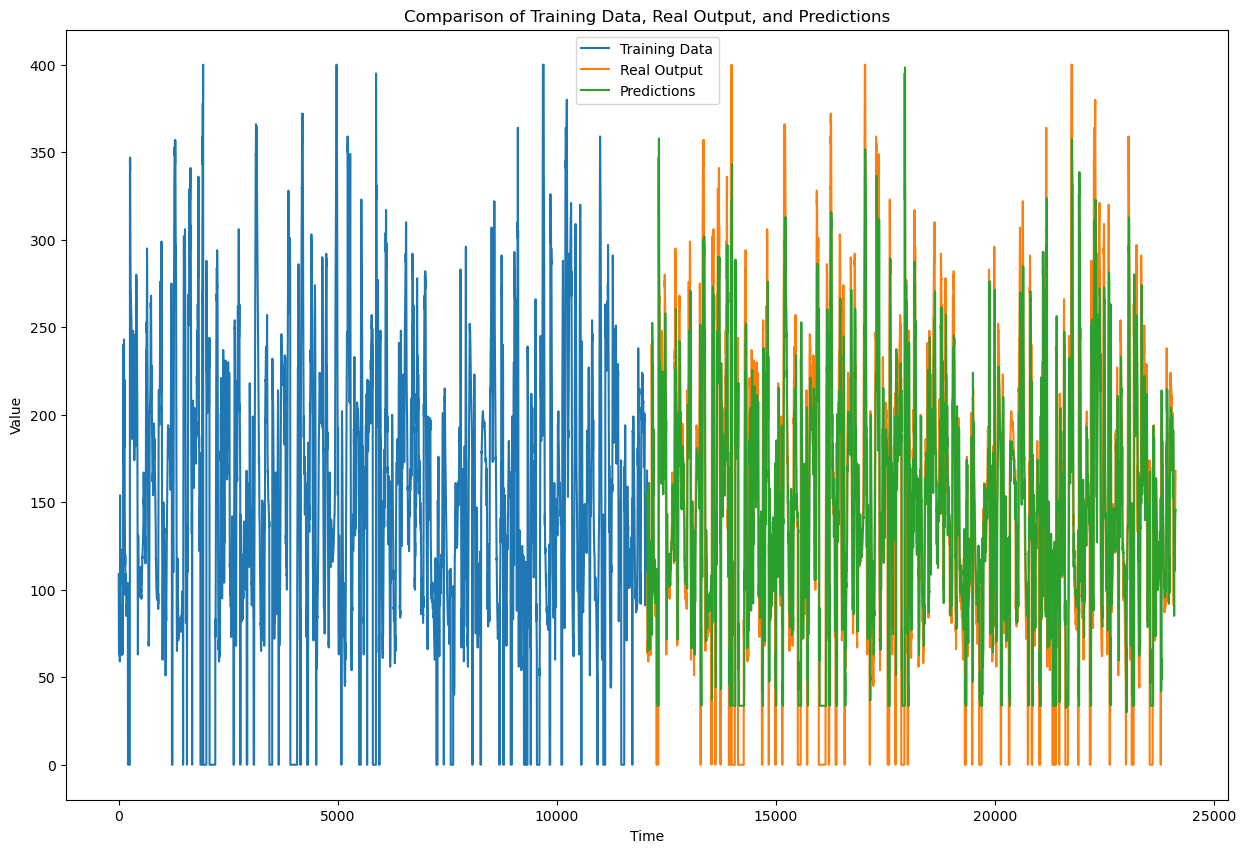

Score (RMSE): 60.100801754872656


In [27]:
# Set the size of the figure
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plotting the training data (y_train)
plt.plot(np.arange(len(y_train)), y_train, label='Training Data')

# Plotting the real output (y_test)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Real Output')

# Plotting the predictions (pred)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), pred, label='Predictions')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Training Data, Real Output, and Predictions')
plt.legend()

# Show plot
plt.show()

# Calculating and printing the RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

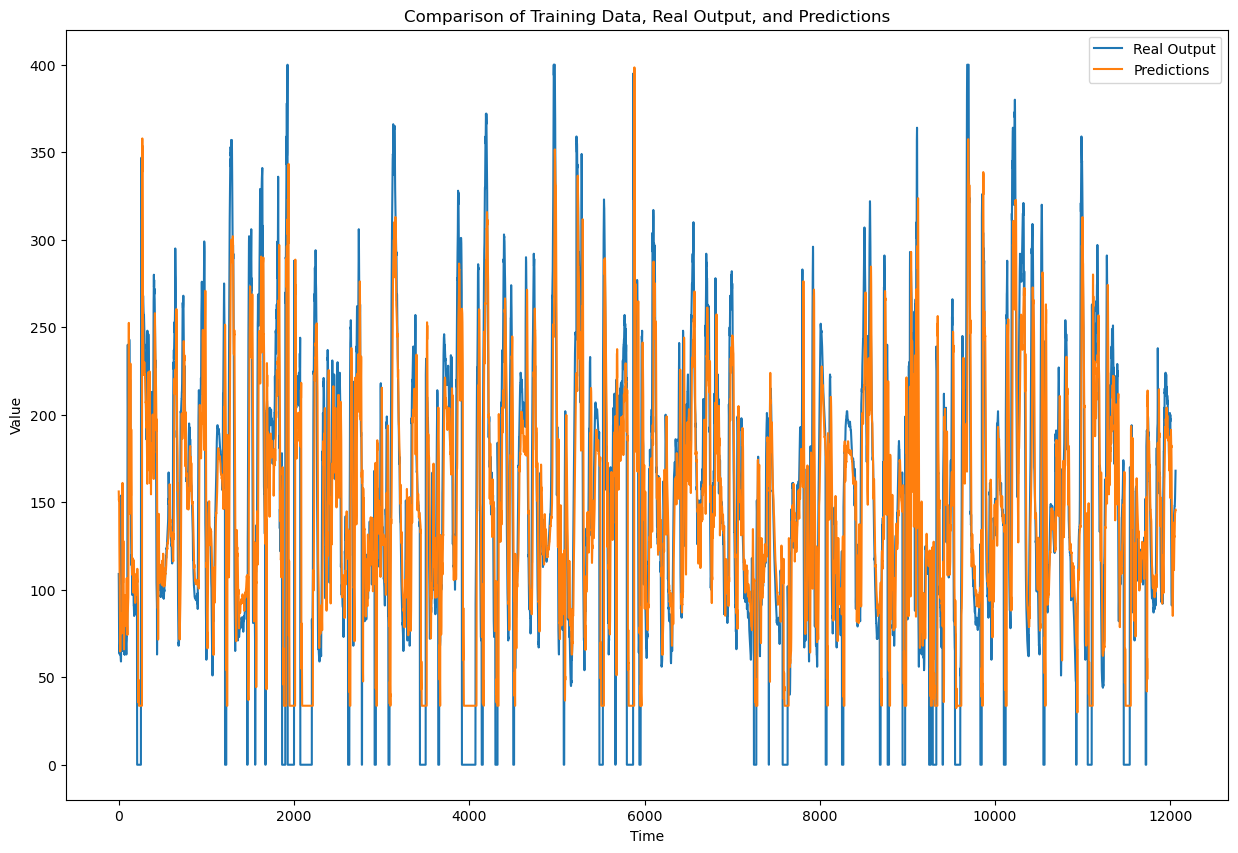

Score (RMSE): 60.100801754872656


In [26]:
# Set the size of the figure
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plotting the real output (y_test)
plt.plot(np.arange(len(y_test)), y_test, label='Real Output')

# Plotting the predictions (pred)
plt.plot(np.arange(len(y_test)), pred, label='Predictions')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Training Data, Real Output, and Predictions')
plt.legend()

# Show plot
plt.show()

# Calculating and printing the RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

## Transformer encoder (N PARAMS)

### DATASET

In [17]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
train = preprocess_data(train)

C:\Users\tesfa\AppData\Local\Temp/ipykernel_10844/4097949453.py:33: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  dataset['timestamp'] = dataset['time'].astype('int64')


In [33]:
SEQUENCE_SIZE = 12
PREDICTION_TIME = 6
BATCH_SIZE = 128

# Order by correlation and variance
sequence_columns = [   
    'glucose_level',
    'basis_heart_rate', 
    'basis_sleep', 
    'basis_step', 
    'basal',
    'finger_stick', 
    'basis_skin_temperature', 
    'basis_air_temperature',
    'work', 
    'exercise', 
    'bolus', 
    'meal', 
    'stressors', 
    'illness',
    'type_of_meal', 
    'hypo_event', 
    'basis_gsr', 
    'sleep'
] 

target_columns = ['glucose_level'] 
   
# Call your function to generate sequences
X, Y = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

# Filter function to check if any value is 0
def filter_zero(x, y):
    # return not tf.reduce_any(tf.equal(x, 0)) and not tf.equal(y, 0)
    return not tf.equal(y, 0)

# Create TensorFlow datasets for training
train_dataset = (tf.data.Dataset
                 .from_tensor_slices((x_train, y_train))
                 .batch(BATCH_SIZE)
                 .shuffle(len(x_train))
                 .prefetch(tf.data.experimental.AUTOTUNE)
                #  .filter(lambda x, y: tf.reduce_all(y != 0))
                )

# Create TensorFlow datasets for validation
validation_dataset = (tf.data.Dataset
               .from_tensor_slices((x_val, y_val))
               .batch(BATCH_SIZE)
               .prefetch(tf.data.experimental.AUTOTUNE)
            #    .filter(lambda x, y: tf.reduce_all(y != 0))
                )
               
# Example usage of the dataset
for x, y in train_dataset.take(1):
    print("Training X shape:", x.shape)
    print("Training Y shape:", y.shape)

for x, y in validation_dataset.take(1):
    print("Validation X shape:", x.shape)
    print("Validation Y shape:", y.shape)

Training X shape: (128, 12, 18)
Training Y shape: (128, 1)
Validation X shape: (128, 12, 18)
Validation Y shape: (128, 1)


### DEFINE MODEL

In [34]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    attention = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )
    x = norm(inputs)
    x = attention(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x += inputs  # Residual connection

    # Feed Forward Part
    x = norm(x)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x += inputs  # Residual connection
    return x

In [35]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    learning_rate=1e-4,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

### BUILD MODEL

In [36]:
input_shape = x_train.shape[1:]

# Build and compile the model
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    learning_rate=1e-4,
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 18)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 12, 18)               36        ['input_1[0][0]',             
 Normalization)                                                      'tf.__operators__.add[0][0]']
                                                                                                  
 multi_head_attention (Mult  (None, 12, 18)               76818     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                             

### TRAIN

In [37]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint("Models/model_checkpoint.h5", save_best_only=True),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5),
    # tf.keras.callbacks.TensorBoard(log_dir="logs"),
    # tf.keras.callbacks.CSVLogger("training.log"),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)),
    # tf.keras.callbacks.TerminateOnNaN(),
    # tf.keras.callbacks.RemoteMonitor(root='http://localhost:9000'),
    # tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']}, Val_loss: {logs['val_loss']}"))
]

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
)

model.save(f"{model_dir}/model")

Epoch 1/50

71/71 [==============================] - 25s 207ms/step - loss: 28905.2246 - val_loss: 26670.1719
Epoch 2/50
71/71 [==============================] - 13s 177ms/step - loss: 24359.7695 - val_loss: 22236.5508
Epoch 3/50
71/71 [==============================] - 13s 188ms/step - loss: 19952.3828 - val_loss: 17681.3047
Epoch 4/50
71/71 [==============================] - 13s 177ms/step - loss: 15569.2607 - val_loss: 13401.6885
Epoch 5/50
71/71 [==============================] - 13s 187ms/step - loss: 11677.0752 - val_loss: 9883.0176
Epoch 6/50
71/71 [==============================] - 13s 189ms/step - loss: 8855.5586 - val_loss: 7493.1313
Epoch 7/50
71/71 [==============================] - 15s 206ms/step - loss: 7041.6934 - val_loss: 6088.8716
Epoch 8/50
71/71 [==============================] - 15s 208ms/step - loss: 6088.2407 - val_loss: 5400.5142
Epoch 9/50
71/71 [==============================] - 14s 196ms/step - loss: 5651.9673 - val_loss: 5111.6987
Epoch 10/50
71/71 [========

INFO:tensorflow:Assets written to: ./Models/model\assets


### TEST

#### LOAD MODEL

In [38]:
loaded_model = tf.keras.saving.load_model(f"{model_dir}/model")
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 18)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 12, 18)               36        ['input_1[0][0]',             
 Normalization)                                                      'tf.__operators__.add[0][0]']
                                                                                                  
 multi_head_attention (Mult  (None, 12, 18)               76818     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

#### LOAD TEST DATA

In [39]:
number = 559

train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
test = pd.read_csv(f'{dataset_dir}/{number}/{number}_test.csv', sep=';',encoding = 'unicode_escape', names=columns)

train = preprocess_data(train)
test = preprocess_data(test)

C:\Users\tesfa\AppData\Local\Temp/ipykernel_10844/4097949453.py:33: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  dataset['timestamp'] = dataset['time'].astype('int64')


In [41]:
SEQUENCE_SIZE = 12
PREDICTION_TIME = 6

# Order by correlation and variance
sequence_columns = [
    'glucose_level',
    'basis_heart_rate',
    'basis_sleep',
    'basis_step',
    'basal',
    'finger_stick',
    'basis_skin_temperature',
    'basis_air_temperature',
    'work',
    'exercise',
    'bolus',
    'meal',
    'stressors',
    'illness',
    'type_of_meal',
    'hypo_event',
    'basis_gsr',
    'sleep'
]

target_columns = ['glucose_level']

x_test, y_test = to_sequences_multi(test, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
print("Shape of train set: {}".format(x_train.shape))
print("Shape of test x set: {}".format(x_test.shape))
print("Shape of test y set: {}".format(y_test.shape))

Shape of train set: (9048, 12, 18)
Shape of test x set: (2857, 12, 18)
Shape of test y set: (2857, 1)


#### TEST

In [42]:
pred = loaded_model.predict(x_test)

90/90 [==============================] - 3s 21ms/step


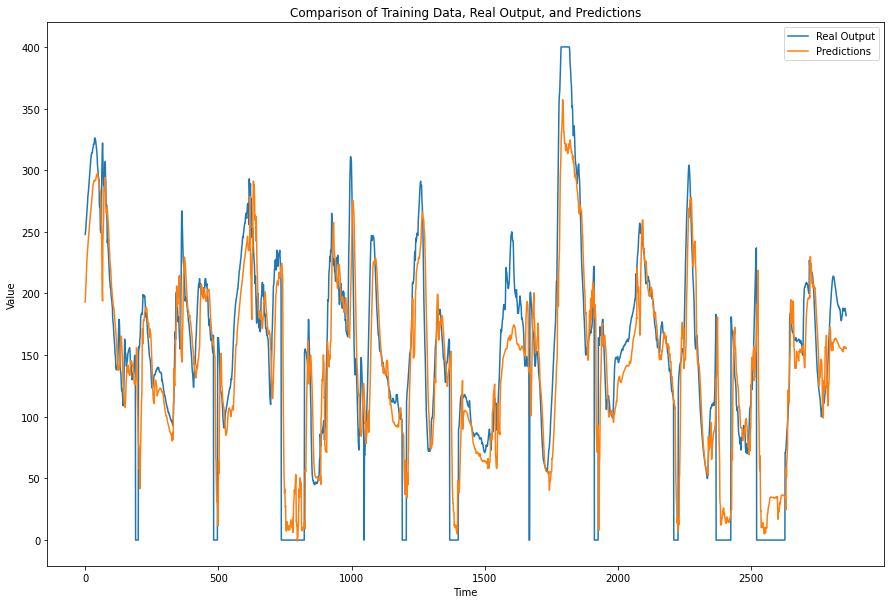

Score (RMSE): 43.56520898542623


In [43]:
# Set the size of the figure
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plotting the real output (y_test)
plt.plot(np.arange(len(y_test)), y_test, label='Real Output')

# Plotting the predictions (pred)
plt.plot(np.arange(len(pred)), pred, label='Predictions')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Training Data, Real Output, and Predictions')
plt.legend()

# Show plot
plt.show()

# Calculating and printing the RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

## RNN

## LSTM

### DATASET

In [61]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
train = preprocess_data(train, time_index=False)

In [62]:
SEQUENCE_SIZE = 10
PREDICTION_TIME = 6
# Order by correlation and variance
sequence_columns = [   
    'glucose_level',
    'basis_heart_rate', 
    'basis_sleep', 
    'basis_step', 
    'basal',
    'finger_stick', 
    'basis_skin_temperature', 
    'basis_air_temperature',
    'work', 
    'exercise', 
    'bolus', 
    'meal', 
    'stressors', 
    'illness',
    'type_of_meal', 
    'hypo_event', 
    'basis_gsr', 
    'sleep'
] 

target_columns = ['glucose_level'] 

x_train, y_train = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
x_train_time, _ = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, ['timestamp'], target_columns)
print("Shape of x training set: {}".format(x_train.shape))
print("Shape of y training set: {}".format(y_train.shape))
print("Shape of x time training set: {}".format(x_train_time.shape))

Shape of x training set: (12066, 10, 18)
Shape of y training set: (12066, 1)
Shape of x time training set: (12066, 10, 1)


### DEFINE MODEL

In [66]:
def build_model(input_shape):
    input_features = tf.keras.layers.Input(shape=input_shape)

    # LSTM layers for input features
    lstm_output = tf.keras.layers.LSTM(512, return_sequences=True)(input_features)
    lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)
    
    # Additional LSTM layer
    lstm_output = tf.keras.layers.LSTM(512, return_sequences=True)(lstm_output)
    lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)

    # Additional LSTM layer
    lstm_output = tf.keras.layers.LSTM(512, return_sequences=True)(lstm_output)
    lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)

    # Additional LSTM layer
    lstm_output = tf.keras.layers.LSTM(512, return_sequences=False)(lstm_output)
    lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)

    # Dense layers
    dense_output = tf.keras.layers.Dense(128, activation='relu')(lstm_output)
    output = tf.keras.layers.Dense(1, activation='linear')(dense_output)

    model = tf.keras.models.Model(inputs=input_features, outputs=output)
    return model


### BUILD MODEL

In [72]:
input_shape = x_train.shape[1:]

# Build the model
model = build_model(input_shape)

# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 18)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 10, 512)           1087488   
                                                                 
 dropout_21 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_23 (LSTM)              (None, 10, 512)           2099200   
                                                                 
 dropout_22 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_24 (LSTM)              (None, 10, 512)           2099200   
                                                                 
 dropout_23 (Dropout)        (None, 10, 512)           0   

### CALLBACKS

In [73]:
class PlotLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.yscale('log')
        plt.show()

### TRAIN

In [74]:
plot_loss = PlotLossCallback()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    plot_loss
    # tf.keras.callbacks.ModelCheckpoint("Models/model_checkpoint.h5", save_best_only=True),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5),
    # tf.keras.callbacks.TensorBoard(log_dir="logs"),
    # tf.keras.callbacks.CSVLogger("training.log"),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)),
    # tf.keras.callbacks.TerminateOnNaN(),
    # tf.keras.callbacks.RemoteMonitor(root='http://localhost:9000'),
    # tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']}, Val_loss: {logs['val_loss']}"))
]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

model.save(f"{model_dir}/model")

Epoch 1/10
 52/151 [=========>....................] - ETA: 1:10 - loss: 12102.9863

KeyboardInterrupt: 

### TEST

#### LOAD MODEL

In [55]:
loaded_model = tf.keras.saving.load_model(f"{model_dir}/model")
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 10, 18)]             0         []                            
                                                                                                  
 lstm_7 (LSTM)               (None, 10, 128)              75264     ['input_5[0][0]']             
                                                                                                  
 dropout_7 (Dropout)         (None, 10, 128)              0         ['lstm_7[0][0]']              
                                                                                                  
 lstm_8 (LSTM)               (None, 10, 128)              131584    ['dropout_7[0][0]']           
                                                                                            

#### LOAD TEST DATA

In [56]:
number = 559

train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
test = pd.read_csv(f'{dataset_dir}/{number}/{number}_test.csv', sep=';',encoding = 'unicode_escape', names=columns)

train = preprocess_data(train, time_index=False)
test = preprocess_data(test, time_index=False)

In [58]:
SEQUENCE_SIZE = 10
PREDICTION_TIME = 6

# Order by correlation and variance
sequence_columns = [
    'glucose_level',
    'basis_heart_rate',
    'basis_sleep',
    'basis_step',
    'basal',
    'finger_stick',
    'basis_skin_temperature',
    'basis_air_temperature',
    'work',
    'exercise',
    'bolus',
    'meal',
    'stressors',
    'illness',
    'type_of_meal',
    'hypo_event',
    'basis_gsr',
    'sleep'
]

target_columns = ['glucose_level']

x_test, y_test = to_sequences_multi(test, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
x_test_time, _ = to_sequences_multi(test, SEQUENCE_SIZE, PREDICTION_TIME, ['timestamp'], target_columns)
print("Shape of x test set: {}".format(x_test.shape))
print("Shape of y test set: {}".format(y_test.shape))
print("Shape of x time test set: {}".format(x_test_time.shape))

Shape of x test set: (2859, 10, 18)
Shape of y test set: (2859, 1)
Shape of x time test set: (2859, 10, 1)


#### TEST

In [59]:
pred = loaded_model.predict([x_test, x_test_time])
pred.shape

90/90 [==============================] - 3s 20ms/step


(2859, 1)

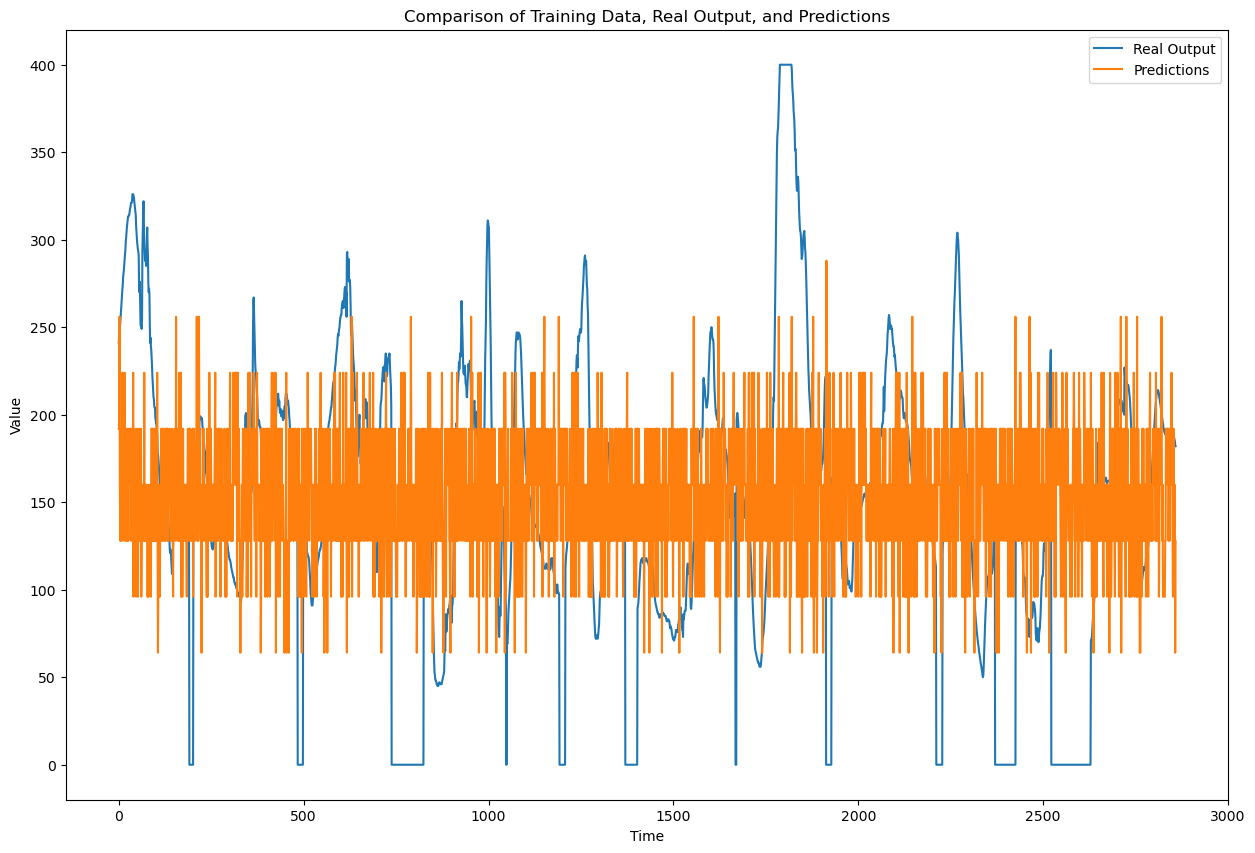

Score (RMSE): 92.22956934266874


In [60]:
# Set the size of the figure
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plotting the real output (y_test)
plt.plot(np.arange(len(y_test)), y_test, label='Real Output')

# Plotting the predictions (pred)
plt.plot(np.arange(len(pred)), pred, label='Predictions')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Training Data, Real Output, and Predictions')
plt.legend()

# Show plot
plt.show()

# Calculating and printing the RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

## PROPHET (META)

### DATASET

In [40]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
train = preprocess_data(train, time_index=False)

In [41]:
# Prepare the data
df_prophet = pd.DataFrame()  # Assuming train is your DataFrame

# Add additional regressors
df_prophet['y'] = train['glucose_level']
df_prophet['ds'] = train['timestamp']

df_prophet['regressor_1'] = train['basis_heart_rate']
df_prophet['regressor_2'] = train['basis_sleep']
df_prophet['regressor_3'] = train['basis_step']
df_prophet['regressor_4'] = train['basal']
df_prophet['regressor_5'] = train['finger_stick']
df_prophet['regressor_6'] = train['basis_skin_temperature']
df_prophet['regressor_7'] = train['basis_air_temperature']
df_prophet['regressor_8'] = train['work']
df_prophet['regressor_9'] = train['exercise']
df_prophet['regressor_10'] = train['bolus']
df_prophet['regressor_11'] = train['meal']

### BUILD MODEL

In [42]:
# Initialize and fit the model
model_prophet = Prophet()

model_prophet.add_regressor('regressor_1')
model_prophet.add_regressor('regressor_2')
model_prophet.add_regressor('regressor_3')
model_prophet.add_regressor('regressor_4')
model_prophet.add_regressor('regressor_5')
model_prophet.add_regressor('regressor_6')
model_prophet.add_regressor('regressor_7')
model_prophet.add_regressor('regressor_8')
model_prophet.add_regressor('regressor_9')
model_prophet.add_regressor('regressor_10')
model_prophet.add_regressor('regressor_11')

### TRAIN

In [44]:
model_prophet.fit(df_prophet)

21:00:15 - cmdstanpy - INFO - Chain [1] start processing
21:00:17 - cmdstanpy - INFO - Chain [1] done processing



### TEST

In [54]:
PREDICTION_PERIOD = 60

# Fill missing values in regressor columns using interpolation
train_interpolated = train.interpolate(method='linear')

# Make future dataframe for prediction
future = model_prophet.make_future_dataframe(periods=PREDICTION_PERIOD)  # Define PREDICTION_PERIOD
future['regressor_1'] = future['ds'].map(train_interpolated.set_index('timestamp')['basis_heart_rate']).ffill()
future['regressor_2'] = future['ds'].map(train_interpolated.set_index('timestamp')['basis_sleep']).ffill()
future['regressor_3'] = future['ds'].map(train_interpolated.set_index('timestamp')['basis_step']).ffill()
future['regressor_4'] = future['ds'].map(train_interpolated.set_index('timestamp')['basal']).ffill()
future['regressor_5'] = future['ds'].map(train_interpolated.set_index('timestamp')['finger_stick']).ffill()
future['regressor_6'] = future['ds'].map(train_interpolated.set_index('timestamp')['basis_skin_temperature']).ffill()
future['regressor_7'] = future['ds'].map(train_interpolated.set_index('timestamp')['basis_air_temperature']).ffill()
future['regressor_8'] = future['ds'].map(train_interpolated.set_index('timestamp')['work']).ffill()
future['regressor_9'] = future['ds'].map(train_interpolated.set_index('timestamp')['exercise']).ffill()
future['regressor_10'] = future['ds'].map(train_interpolated.set_index('timestamp')['bolus']).ffill()
future['regressor_11'] = future['ds'].map(train_interpolated.set_index('timestamp')['meal']).ffill()

# Make predictions
forecast = model_prophet.predict(future)

# Plot forecast
fig = model_prophet.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Glucose Level')
plt.title('Glucose Level Forecast with Regressors')
plt.show()

ValueError: Found NaN in column 'regressor_1'

## DNN-ARIMA

### DATASET

In [ ]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
train = preprocess_data(train)

In [ ]:
SEQUENCE_SIZE = 24
PREDICTION_TIME = 6
# Order by correlation and variance
sequence_columns = [   
    'glucose_level',
    'basis_heart_rate', 
    'basis_sleep', 
    'basis_step', 
    'basal',
    'finger_stick', 
    'basis_skin_temperature', 
    'basis_air_temperature',
    'work', 
    'exercise', 
    'bolus', 
    'meal', 
    'stressors', 
    'illness',
    'type_of_meal', 
    'hypo_event', 
    'basis_gsr', 
    'sleep'
] 

target_columns = ['glucose_level'] 

x_train, y_train = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
print("Shape of training set: {}".format(x_train.shape))

### DEFINE MODEL

In [ ]:
def create_dnn_model(input_shape):
    model = tf.keras.layers.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # ARIMA output
    arima_output = x
    
    # DNN output 
    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    dnn_output = tf.keras.layers.Dense(1)(x)
    
    # Combine outputs
    outputs = tf.keras.layers.add([arima_output, dnn_output])
    
    return tf.keras.Model(inputs, outputs)

### BUILD MODEL

In [ ]:
input_shape = x_train.shape[1:]

# Build the model
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    dropout=0.25,
)

# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

### TRAIN

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint("Models/model_checkpoint.h5", save_best_only=True),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5),
    # tf.keras.callbacks.TensorBoard(log_dir="logs"),
    # tf.keras.callbacks.CSVLogger("training.log"),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)),
    # tf.keras.callbacks.TerminateOnNaN(),
    # tf.keras.callbacks.RemoteMonitor(root='http://localhost:9000'),
    # tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']}, Val_loss: {logs['val_loss']}"))
]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
)

model.save(f"{model_dir}/model")

### TEST

#### LOAD MODEL

In [ ]:
loaded_model = tf.keras.saving.load_model(f"{model_dir}/model")
loaded_model.summary()

#### LOAD TEST DATA

In [ ]:
number = 570

train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
test = pd.read_csv(f'{dataset_dir}/{number}/{number}_test.csv', sep=';',encoding = 'unicode_escape', names=columns)

train = preprocess_data(train)
test = preprocess_data(test)

In [ ]:
SEQUENCE_SIZE = 24
PREDICTION_TIME = 6

# Order by correlation and variance
sequence_columns = [
    'glucose_level',
    'basis_heart_rate',
    'basis_sleep',
    'basis_step',
    'basal',
    'finger_stick',
    'basis_skin_temperature',
    'basis_air_temperature',
    'work',
    'exercise',
    'bolus',
    'meal',
    'stressors',
    'illness',
    'type_of_meal',
    'hypo_event',
    'basis_gsr',
    'sleep'
]

target_columns = ['glucose_level']

x_test, y_test = to_sequences_multi(test, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
print("Shape of train set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print("Shape of test set: {}".format(y_test.shape))

#### TEST

In [ ]:
# Set the size of the figure
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plotting the real output (y_test)
plt.plot(np.arange(len(y_test)), y_test, label='Real Output')

# Plotting the predictions (pred)
plt.plot(np.arange(len(pred)), pred, label='Predictions')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Training Data, Real Output, and Predictions')
plt.legend()

# Show plot
plt.show()

# Calculating and printing the RMSE score
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

## DEEP RESIDUAL

### DATASET

In [8]:
number = 559
train = pd.read_csv(f'{dataset_dir}/{number}/{number}_train.csv', sep=';',encoding = 'unicode_escape', names=columns)
train = preprocess_data(train, time_index=False)

C:\Users\tesfa\AppData\Local\Temp/ipykernel_18232/4097949453.py:33: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  dataset['timestamp'] = dataset['time'].astype('int64')


In [10]:
SEQUENCE_SIZE = 24
PREDICTION_TIME = 6
# Order by correlation and variance
sequence_columns = [   
    'glucose_level',
    'basis_heart_rate', 
    'basis_sleep', 
    'basis_step', 
    'basal',
    'finger_stick', 
    'basis_skin_temperature', 
    'basis_air_temperature',
    'work', 
    'exercise', 
    'bolus', 
    'meal', 
    'stressors', 
    'illness',
    'type_of_meal', 
    'hypo_event', 
    'basis_gsr', 
    'sleep'
] 

target_columns = ['glucose_level'] 

x_train, y_train = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, sequence_columns, target_columns)
# x_train_time, _ = to_sequences_multi(train, SEQUENCE_SIZE, PREDICTION_TIME, ['timestamp'], target_columns)
print("Shape of x training set: {}".format(x_train.shape))
print("Shape of y training set: {}".format(y_train.shape))
# print("Shape of x time training set: {}".format(x_train_time.shape))

Shape of x training set: (12052, 24, 18)
Shape of y training set: (12052, 1)
Shape of x time training set: (12066, 10, 1)


### DEFINE MODEL

In [16]:
def residual_block(inputs, units, horizon):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True))(inputs)
    backcast = tf.keras.layers.Dense(inputs.shape[1], activation='linear', name='backcast')(x)
    forecast = tf.keras.layers.Dense(horizon, activation='linear', name='forecast')(x)
    return backcast, forecast

In [17]:
def reconstruction_loss(y_true, y_pred, horizon):
    y_true, _ = tf.split(y_true, [y_true.shape[1] - horizon, horizon], axis=1)
    return tf.reduce_mean(tf.square(y_true - y_pred))

def forecast_loss(y_true, y_pred, horizon):
    _, y_true = tf.split(y_true, [y_true.shape[1] - horizon, horizon], axis=1)
    return tf.reduce_mean(tf.square(y_true - y_pred))

def magnitude_loss(y_true, y_pred):
    return tf.reduce_mean(1.0 / (tf.abs(y_pred) + 1e-6))

In [18]:
def build_model(input_shape, num_blocks, units, horizon, beta, gamma):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs

    backcast_losses = []
    forecast_losses = []
    magnitude_losses = []

    for i in range(num_blocks):
        backcast, forecast = residual_block(x, units, horizon)
        backcast_losses.append(reconstruction_loss(inputs, backcast, horizon))
        forecast_losses.append(forecast_loss(inputs, tf.concat([backcast, forecast], axis=1), horizon))
        magnitude_losses.append(magnitude_loss(inputs, backcast))
        x = inputs - backcast

    total_backcast_loss = tf.reduce_sum(tf.stack(backcast_losses, axis=0) * tf.range(1, num_blocks + 1, dtype=tf.float32)) / tf.reduce_sum(tf.range(1, num_blocks + 1, dtype=tf.float32))
    total_forecast_loss = tf.reduce_sum(tf.stack(forecast_losses, axis=0) * tf.pow(tf.range(1, num_blocks + 1, dtype=tf.float32), 3)) / tf.reduce_sum(tf.pow(tf.range(1, num_blocks + 1, dtype=tf.float32), 3))
    total_magnitude_loss = tf.reduce_sum(tf.stack(magnitude_losses, axis=0) * 1.0 / tf.range(1, num_blocks + 1, dtype=tf.float32)) / tf.reduce_sum(1.0 / tf.range(1, num_blocks + 1, dtype=tf.float32))

    total_loss = total_forecast_loss + beta * total_backcast_loss + gamma * total_magnitude_loss

    model = tf.keras.models.Model(inputs=inputs, outputs=forecast, name='deep_residual_forecaster')
    model.add_loss(total_loss)
    return model

### BUILD MODEL

In [19]:
input_shape = x_train.shape[1:]

# Build the model
model = build_model(input_shape, num_blocks=7, units=300, horizon=6, beta=0.3, gamma=1e-4)

# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

model.summary()

ValueError: Exception encountered when calling layer "tf.math.subtract" (type TFOpLambda).

Dimensions must be equal, but are 18 and 24 for '{{node tf.math.subtract/Sub}} = Sub[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [?,18,18], [?,24,24].

Call arguments received by layer "tf.math.subtract" (type TFOpLambda):
  • x=tf.Tensor(shape=(None, 18, 18), dtype=float32)
  • y=tf.Tensor(shape=(None, 24, 24), dtype=float32)
  • name=None

### TRAIN

In [ ]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint("Models/model_checkpoint.h5", save_best_only=True),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5),
    # tf.keras.callbacks.TensorBoard(log_dir="logs"),
    # tf.keras.callbacks.CSVLogger("training.log"),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)),
    # tf.keras.callbacks.TerminateOnNaN(),
    # tf.keras.callbacks.RemoteMonitor(root='http://localhost:9000'),
    # tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']}, Val_loss: {logs['val_loss']}"))
]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

model.save(f"{model_dir}/model")